<a href="https://colab.research.google.com/github/ieadoboe/effective-waffle/blob/main/42_cifar10_blur_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Removing Motion Blur from Corrupt CIFAR-10 images


In [1]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time

### Load data


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

### Create motion blur images


In [3]:
# Motion blur angle (do not change)
min_angle = 0
max_angle = 180

In [4]:
# Motion blur generation routines
def create_motion_blur_kernel(size, angle):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = (size - 1) / 2.0

    radian_angle = np.deg2rad(angle)
    dx = np.cos(radian_angle)
    dy = np.sin(radian_angle)
    x1 = int(round(center - dx * center))
    y1 = int(round(center - dy * center))
    x2 = int(round(center + dx * center))
    y2 = int(round(center + dy * center))

    cv2.line(kernel, (x1, y1), (x2, y2), 1.0, thickness=1)

    kernel[kernel < 0] = 0
    kernel_sum = kernel.sum()
    if kernel_sum == 0:
        kernel[int(center), int(center)] = 1.0
    else:
        kernel /= kernel_sum

    return kernel


def add_motion_blur(images, ksize, min_angle, max_angle, seed=123):

    blurred_images = np.zeros_like(images, dtype=np.float32)
    rng = np.random.RandomState(seed)

    for i in range(len(images)):

        image = images[i]

        # Parameters of motion blur kernel
        if ksize % 2 == 0:
            ksize += 1
        angle = rng.uniform(min_angle, max_angle)

        # Create motion blur kernel
        kernel = create_motion_blur_kernel(ksize, angle)

        # Apply kernel
        blurred_img = cv2.filter2D(image, -1, kernel)

        # 5. Clip and store
        blurred_images[i] = np.clip(blurred_img, 0.0, 255.0)

    return blurred_images.astype(np.int16)

In [5]:
# Blur kernel size (change this here)
kernel_size = 7  # default for now

## Motion blurred image generation


In [6]:
x_train_blurred_mild = add_motion_blur(x_train, min_angle=0, max_angle=180, ksize=3)
x_test_blurred_mild = add_motion_blur(x_test, min_angle=0, max_angle=180, ksize=3)

x_train_blurred_medium = add_motion_blur(x_train, min_angle=0, max_angle=180, ksize=7)
x_test_blurred_medium = add_motion_blur(x_test, min_angle=0, max_angle=180, ksize=7)

x_train_blurred_strong = add_motion_blur(x_train, min_angle=0, max_angle=180, ksize=11)
x_test_blurred_strong = add_motion_blur(x_test, min_angle=0, max_angle=180, ksize=11)

In [7]:
# Normalize images
normalize_img = lambda image: image / 255.0

# original images
x_train = normalize_img(x_train)
x_test = normalize_img(x_test)

# mild blur
x_train_blurred_mild = normalize_img(x_train_blurred_mild)
x_test_blurred_mild = normalize_img(x_test_blurred_mild)

# medium blur
x_train_blurred_medium = normalize_img(x_train_blurred_medium)
x_test_blurred_medium = normalize_img(x_test_blurred_medium)

# strong blur
x_train_blurred_strong = normalize_img(x_train_blurred_strong)
x_test_blurred_strong = normalize_img(x_test_blurred_strong)

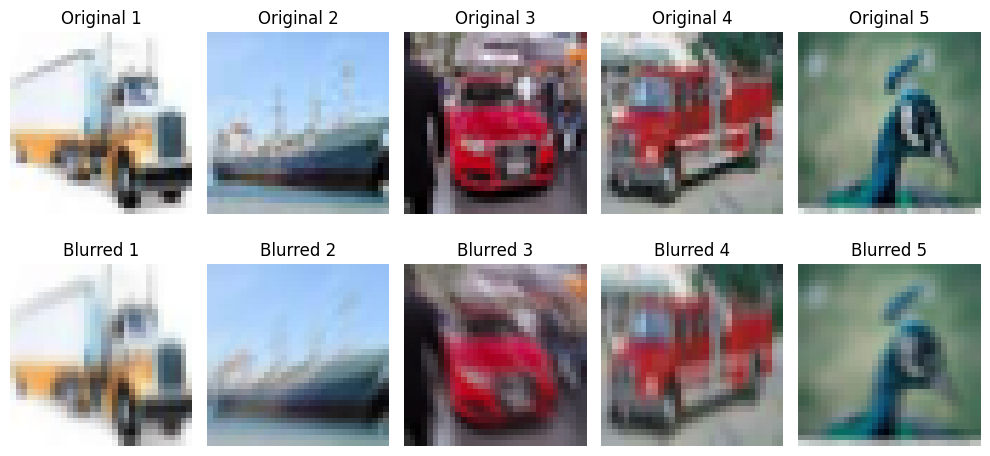

In [8]:
# Visualize some of the blurred data along with the original data
def visualize_blurring(x_orig, x_blurred, num_examples=5):

    num_examples = min(num_examples, len(x_blurred))
    indices = np.random.choice(len(x_blurred), num_examples, replace=False)
    sample_orig = x_orig[indices]
    sample_blurred = x_blurred[indices]

    plt.figure(figsize=(num_examples * 2, 5))
    for i in range(num_examples):

        ax = plt.subplot(2, num_examples, i + 1)
        plt.imshow(sample_orig[i])
        plt.title(f"Original {i+1}")
        plt.axis("off")

        ax = plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(sample_blurred[i])
        plt.title(f"Blurred {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize some of the blurred data
visualize_blurring(x_train, x_train_blurred_mild, num_examples=5)

## Model architecture


We try to utilize the idea from U-Net for a similar implementation.


In [9]:
# UNet architecture from UNet Segmentation notebook (simplified for cifar-10)
inputs = tf.keras.layers.Input(shape=(None, None, 3))

# Encoder
conv1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(pool1)
conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Bottleneck
conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(pool2)
conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(conv3)
drop3 = tf.keras.layers.Dropout(0.5)(conv3)

# Decoder
up4 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(drop3)
merge4 = tf.keras.layers.concatenate([conv2, up4], axis=3)
conv4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(merge4)
conv4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(conv4)

up5 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding="same")(conv4)
merge5 = tf.keras.layers.concatenate([conv1, up5], axis=3)
conv5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(merge5)
conv5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(conv5)

outputs = tf.keras.layers.Conv2D(3, 3, activation="sigmoid", padding="same")(conv5)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        896 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,248 │ conv2d[0][0]      │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,496 │ max_pooling2d[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_2[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     73,856 │ max_pooling2d_1[… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_4[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None,      │          0 │ conv2d_5[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, None,      │     32,832 │ dropout[0][0]     │
│ (Conv2DTranspose)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ None, 128)        │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     73,792 │ concatenate[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_6[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, None,      │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None,      │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ None, 64)         │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │     18,464 │ concatenate_1[0]

 Total params: 467,363 (1.78 MB)

 Trainable params: 467,363 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
EPOCHS = 30

start_time = time.time()

history = model.fit(
    x_train_blurred_medium, x_train, epochs=EPOCHS, batch_size=64, validation_split=0.2
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0158 - mae: 0.0879 - val_loss: 0.0065 - val_mae: 0.0554
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0061 - mae: 0.0543 - val_loss: 0.0045 - val_mae: 0.0470
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0043 - mae: 0.0463 - val_loss: 0.0039 - val_mae: 0.0435
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0037 - mae: 0.0429 - val_loss: 0.0034 - val_mae: 0.0407
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0034 - mae: 0.0409 - val_loss: 0.0031 - val_mae: 0.0392
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0031 - mae: 0.0392 - val_loss: 0.0028 - val_mae: 0.0373
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0030 - mae: 0.0384 - val_loss: 0.0027 - val_mae: 0.0362
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 0.0026 - val_mae: 0.0355
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")


Training time: 8.76 minutes


In [11]:
x_test_blurred_medium[1].shape

(32, 32, 3)

In [12]:
len(x_test_blurred_medium)

10000

In [13]:
def reconstruct_test_images(test_blurred_dataset, test_original_dataset=x_test):
    indices = np.random.choice(10000, 3, replace=False)

    for i in indices:
        blurred_image = test_blurred_dataset[i]  # get image
        blurred_image_batch = np.expand_dims(blurred_image, axis=0)  # batch size = 1
        deblurred_image = model.predict(blurred_image_batch)[0]  # predict image

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.title("Original Image")
        plt.imshow(test_original_dataset[i])
        plt.axis("off")

        plt.subplot(132)
        plt.title("Blurred Image")
        plt.imshow(blurred_image)
        plt.axis("off")

        plt.subplot(133)
        plt.title("Deblurred Image")
        plt.imshow(deblurred_image)
        plt.axis("off")

        plt.show()

### Reconstruction of medium blurred images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


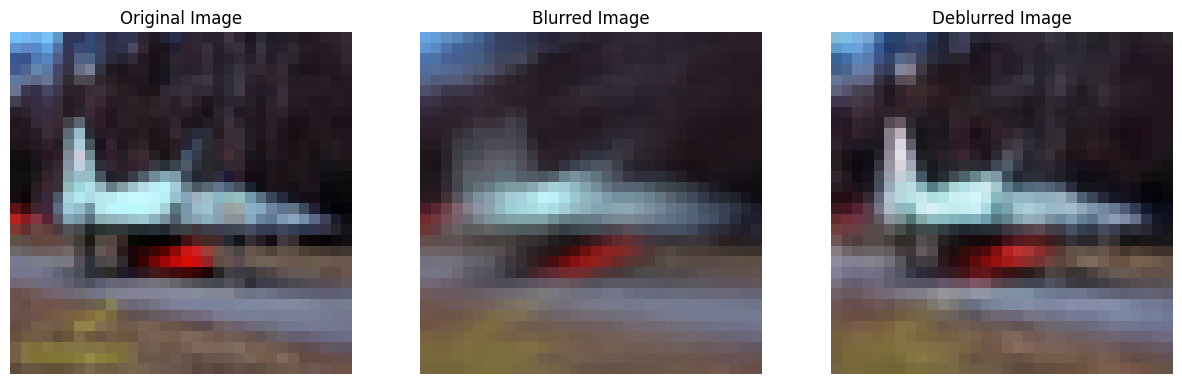

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


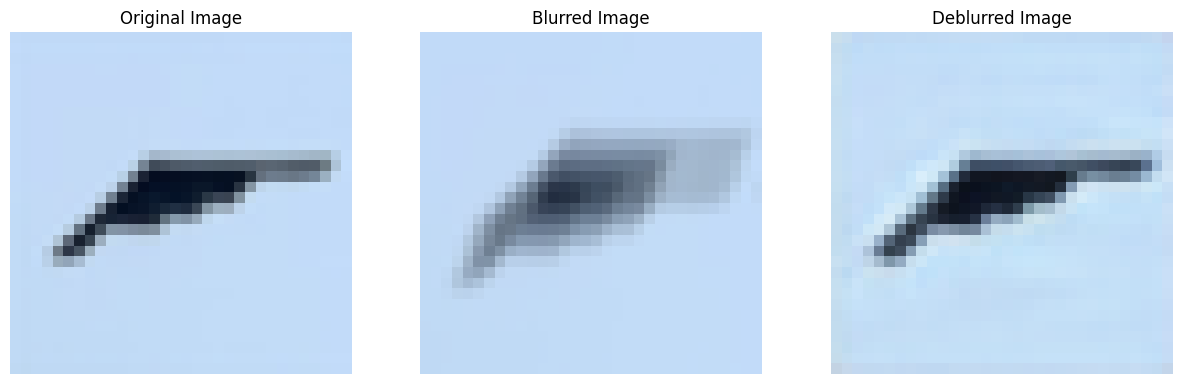

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


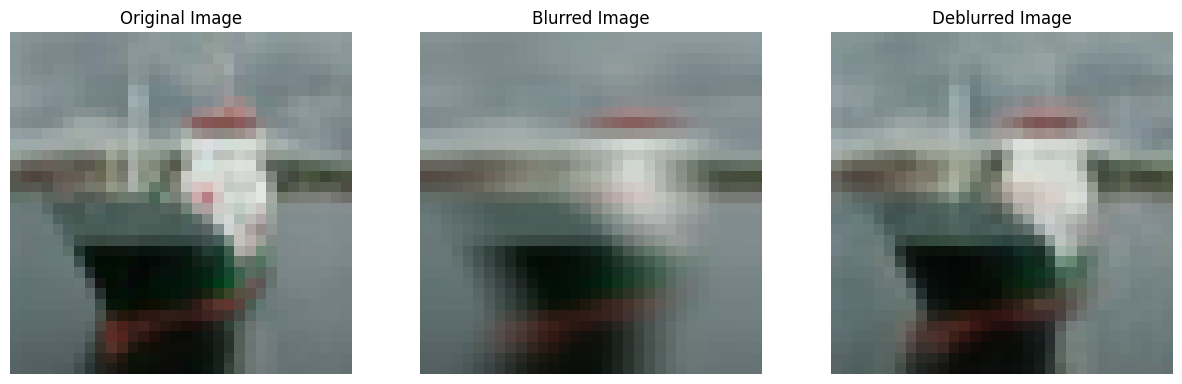

In [40]:
np.random.seed(12)  # set seed
reconstruct_test_images(x_test_blurred_medium)

### Reconstruction of mildly blurred images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


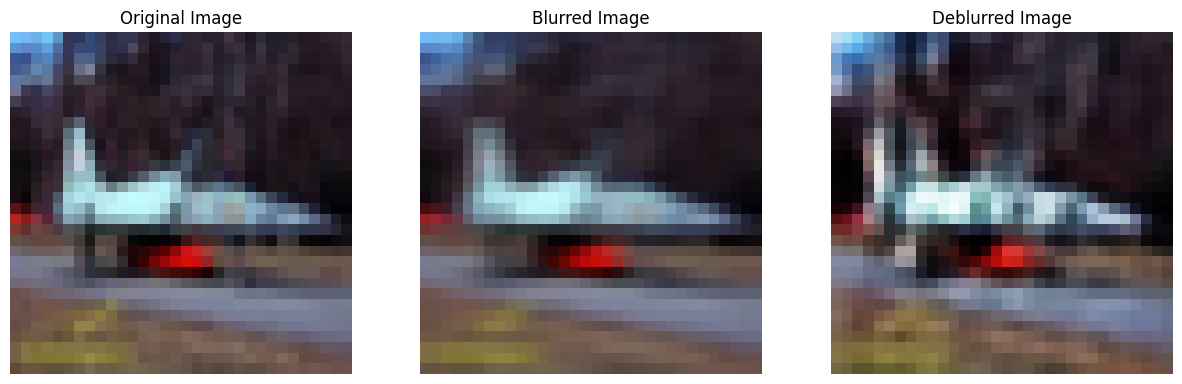

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


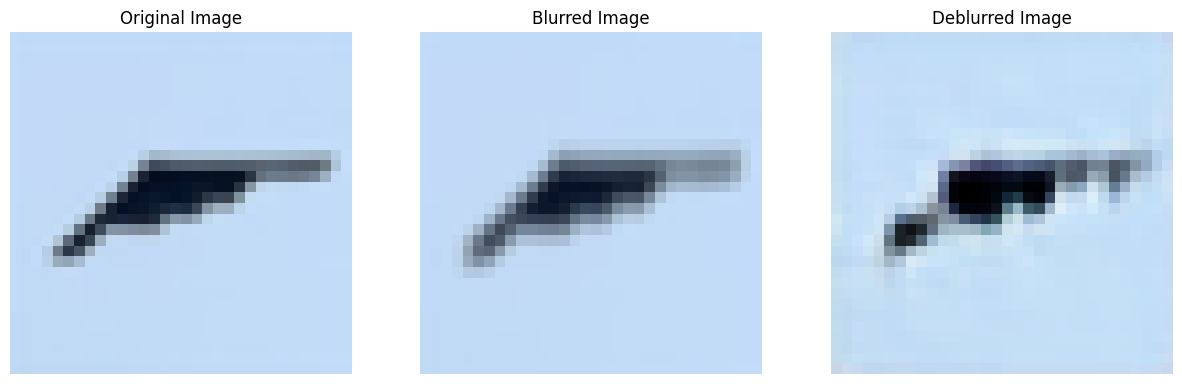

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


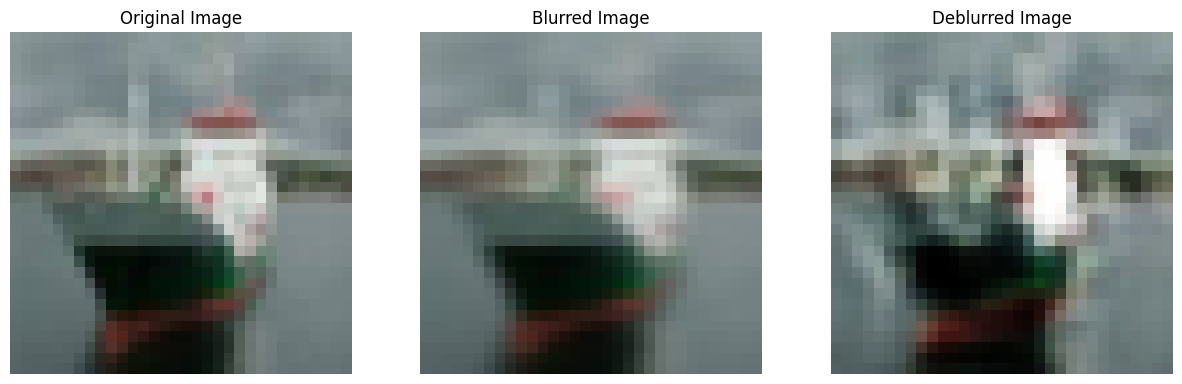

In [14]:
np.random.seed(12)  # set seed
reconstruct_test_images(x_test_blurred_mild)

### Reconstruction of strongly blurred images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


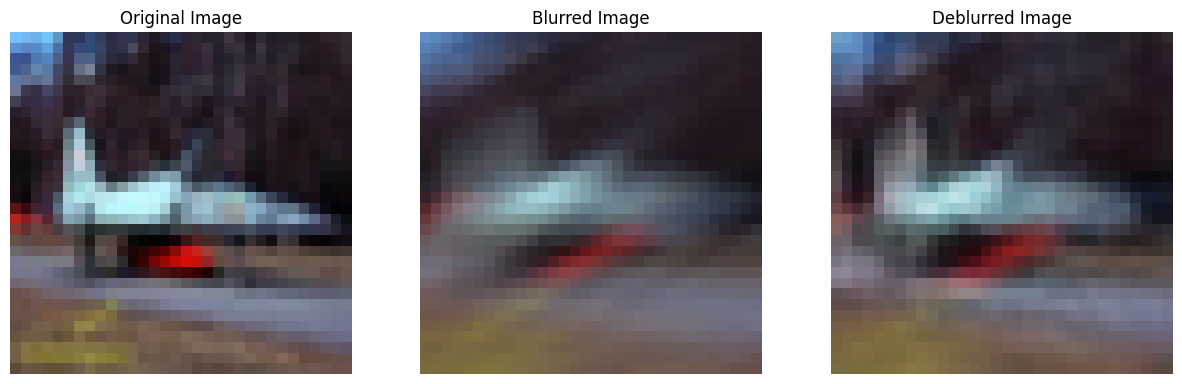

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


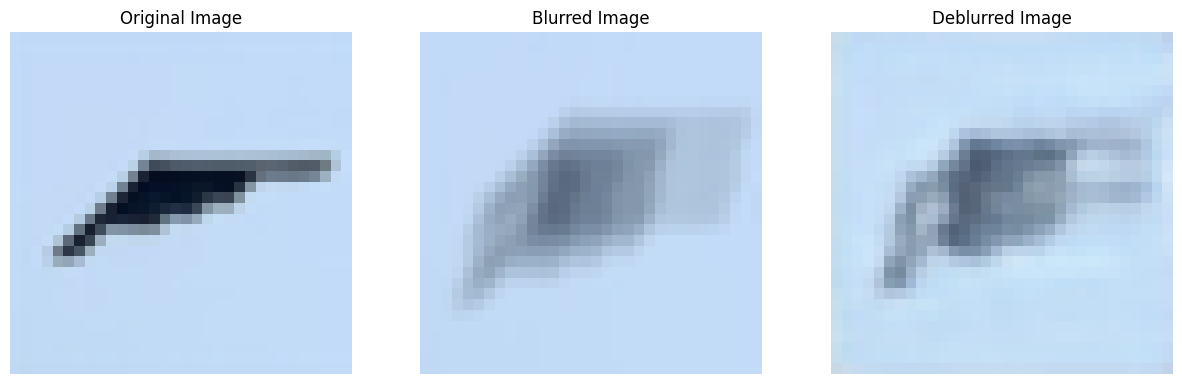

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


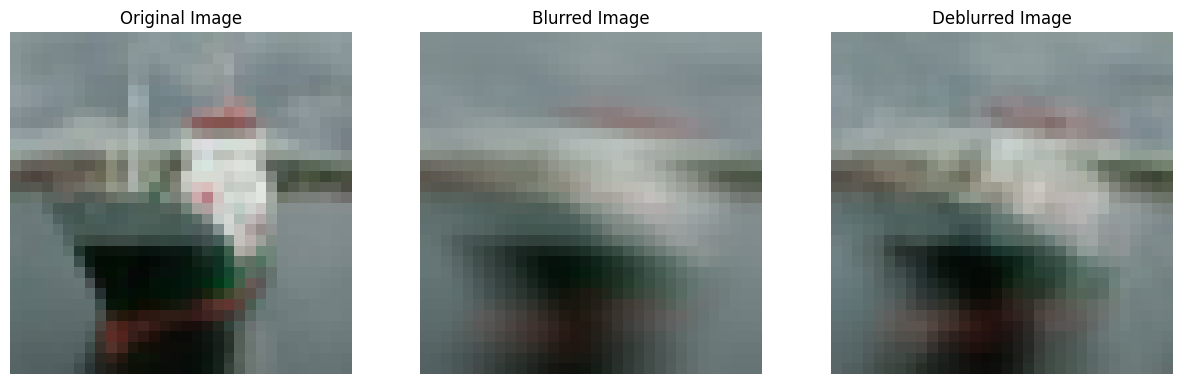

In [15]:
np.random.seed(12)  # set seed
reconstruct_test_images(x_test_blurred_strong)

We can see that for a strongly motion blurred image, the model is able to arguably deblur the image to a point where it is easy to guess for a human.

## Plot metric over test images as a function of corruption strength


### SSIM & PSNR


In [30]:
ssim_metric = lambda y_true, y_pred: tf.image.ssim(y_true, y_pred, max_val=1.0)
psnr_metric = lambda y_true, y_pred: tf.image.psnr(y_true, y_pred, max_val=1.0)

blurred_test_datasets = [
    x_test_blurred_mild,
    x_test_blurred_medium,
    x_test_blurred_strong,
]
corruption_strength = ["mild", "medium", "strong"]

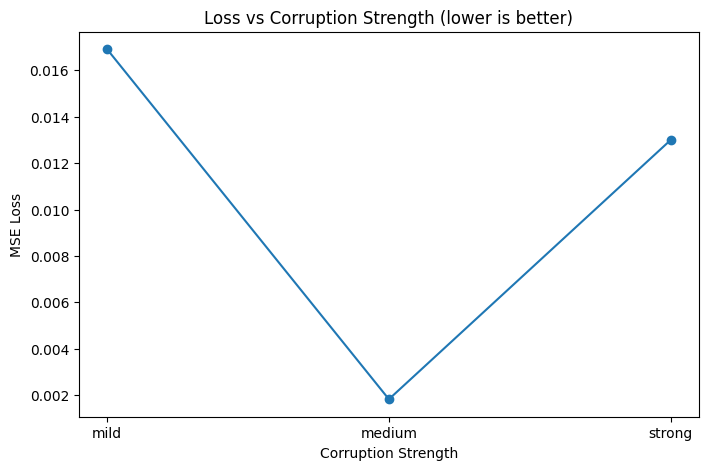

[np.float64(0.01690772068419844),
 np.float64(0.0018274009147670807),
 np.float64(0.012999221113077395)]

In [42]:
def evaluate_loss(original_images, blur_datasets, corruption_strength):
    loss_results = []
    batch_size = 64

    for blur_dataset in blur_datasets:
        blur_ds = tf.data.Dataset.from_tensor_slices(blur_dataset).batch(batch_size)
        orig_ds = tf.data.Dataset.from_tensor_slices(original_images).batch(batch_size)
        combined_ds = tf.data.Dataset.zip((blur_ds, orig_ds))

        losses = []
        for blurred_batch, original_batch in combined_ds:
            blurred_batch = tf.cast(blurred_batch, tf.float32)
            original_batch = tf.cast(original_batch, tf.float32)

            deblurred_batch = model(blurred_batch, training=False)
            loss = tf.reduce_mean(tf.square(original_batch - deblurred_batch))
            losses.append(float(loss))

        loss_results.append(np.mean(losses))

    # Plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(corruption_strength, loss_results, "o-")
    plt.title("Loss vs Corruption Strength (lower is better)")
    plt.xlabel("Corruption Strength")
    plt.ylabel("MSE Loss")
    plt.show()

    return loss_results

evaluate_loss(x_test, blurred_test_datasets, corruption_strength)

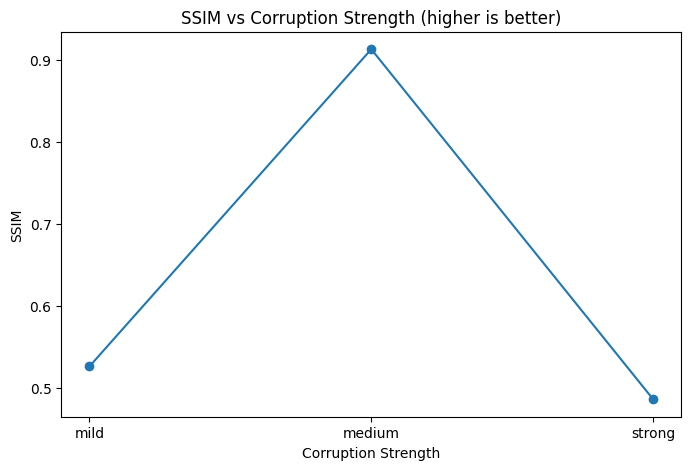

[np.float64(0.5265547253523662),
 np.float64(0.9133573383282704),
 np.float64(0.48655205566412324)]

In [41]:
def evaluate_ssim(
    original_images, blur_datasets, corruption_strength=corruption_strength
):
    ssim_results = []
    batch_size = 64

    for blur_dataset in blur_datasets:
        blur_ds = tf.data.Dataset.from_tensor_slices(blur_dataset).batch(batch_size)
        orig_ds = tf.data.Dataset.from_tensor_slices(original_images).batch(batch_size)
        combined_ds = tf.data.Dataset.zip((blur_ds, orig_ds))

        ssims = []
        for blurred_batch, original_batch in combined_ds:
            blurred_batch = tf.cast(blurred_batch, tf.float32)
            original_batch = tf.cast(original_batch, tf.float32)

            deblurred_batch = model(blurred_batch, training=False)
            ssim = tf.reduce_mean(
                tf.image.ssim(original_batch, deblurred_batch, max_val=1.0)
            )
            if not tf.math.is_nan(ssim):
                ssims.append(float(ssim))

        ssim_results.append(np.mean(ssims) if ssims else 0)

    plt.figure(figsize=(8, 5))
    plt.plot(corruption_strength, ssim_results, "o-")
    plt.title("SSIM vs Corruption Strength (higher is better)")
    plt.xlabel("Corruption Strength")
    plt.ylabel("SSIM")
    plt.show()

    return ssim_results

evaluate_ssim(x_test, blurred_test_datasets)

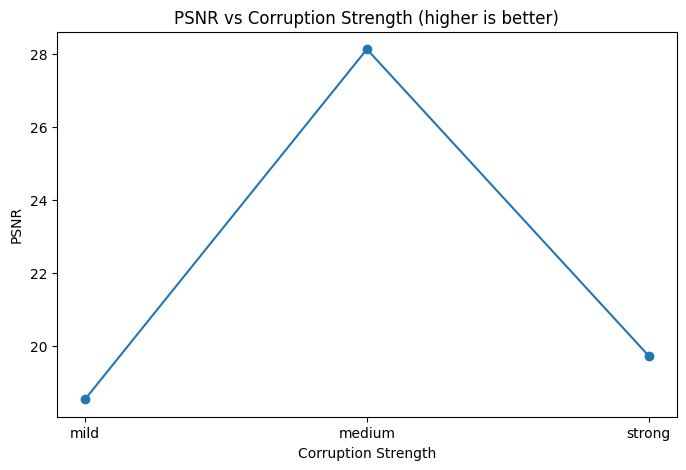

[np.float64(18.547893220451986),
 np.float64(28.123682313663945),
 np.float64(19.73506021195916)]

In [35]:
def evaluate_psnr(
    original_images, blur_datasets, corruption_strength=corruption_strength
):

    psnr_results = []
    batch_size = 64

    for blur_dataset in blur_datasets:
        blur_ds = tf.data.Dataset.from_tensor_slices(blur_dataset).batch(batch_size)
        orig_ds = tf.data.Dataset.from_tensor_slices(original_images).batch(batch_size)
        combined_ds = tf.data.Dataset.zip((blur_ds, orig_ds))

        psnrs = []
        for blurred_batch, original_batch in combined_ds:
            deblurred_batch = model(blurred_batch, training=False)
            psnr = tf.reduce_mean(
                tf.image.psnr(original_batch, deblurred_batch, max_val=1.0)
            )
            if not tf.math.is_nan(psnr):
                psnrs.append(float(psnr))

        psnr_results.append(np.mean(psnrs) if psnrs else 0)

    # Plot PSNR
    plt.figure(figsize=(8, 5))
    plt.plot(corruption_strength, psnr_results, "o-")
    plt.title("PSNR vs Corruption Strength (higher is better)")
    plt.xlabel("Corruption Strength")
    plt.ylabel("PSNR")
    plt.show()

    return psnr_results

evaluate_psnr(x_test, blurred_test_datasets)